<a href="https://colab.research.google.com/github/ishikaarora/pytorch-tutorials/blob/master/cifar_attack_unit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## General setup and import functions

In [0]:
from __future__ import print_function, division
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import random

plt.ion()   # interactive mode

In [0]:
pip install torchattacks

In [0]:
import torchattacks

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/Adversarial/' 

In [0]:
cifar10_mean = [0.49139968 , 0.48215841 , 0.44653091]
cifar10_std = [0.24703223,  0.24348513 , 0.26158784]

In [0]:
BATCH_SIZE = 4

In [7]:
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean,cifar10_std)
])

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified


#### Helper functions

In [0]:
def calculate_accuracy(model, loader, print_freq=1000):
    model.eval()
    total = 0
    correct = 0
    # with torch.no_grad():
    for data in loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

        if total % print_freq == 0:
            print("Current Accuracy: {} / {} = {}".format(correct, total, correct/total*100))
    return (correct/total)*100, total

In [0]:
# FGSM Gradient attack code
def gradient_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # print(inp.shape)
    inp = cifar10_std * inp + cifar10_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Load the main model

In [0]:
class mymodel(nn.Module):
    """Custom Model"""

    def __init__(self, in_features, hidden_dim, n_classes):
        """Custom Model Builder."""
        super(mymodel, self).__init__()
        
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, n_classes)
   
  
    def forward(self, images):
        """Perform forward."""
        
        images_vec = images.view(images.size(0), -1)
        hidden_out = F.relu(self.fc1(images_vec))
        hidden_out = F.relu(self.fc2(hidden_out))
        scores = self.fc3(hidden_out)

        return scores

In [0]:
model = torch.load(root_path+"models/mymodel.pt", map_location=torch.device(device))
# model = torch.load("mymodel.pt", map_location=torch.device(device))
# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

In [0]:
model_acc, data_size = calculate_accuracy(model, testloader)
print(model_acc, data_size)

Current Accuracy: 904 / 1000 = 90.4
Current Accuracy: 1808 / 2000 = 90.4
Current Accuracy: 2707 / 3000 = 90.23333333333333
Current Accuracy: 3603 / 4000 = 90.075
Current Accuracy: 4510 / 5000 = 90.2
Current Accuracy: 5412 / 6000 = 90.2
Current Accuracy: 6312 / 7000 = 90.17142857142856
Current Accuracy: 7211 / 8000 = 90.1375
Current Accuracy: 8126 / 9000 = 90.28888888888889
Current Accuracy: 9036 / 10000 = 90.36
90.36 10000


## Atack functions

### FGSM Attack

In [0]:
# FGSM Attack
def fgsm_attack(model, data, target, **kwargs):
    loss_fn = kwargs.get('loss_fn', nn.CrossEntropyLoss())
    epsilon = kwargs.get('epsilon', 0.1)
    data.requires_grad = True
    
    output = model(data)
    loss = loss_fn(output,target) 
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = gradient_attack(data, epsilon, data_grad)

    return perturbed_data

### Transferability Attack

Load pretrained model on CIFAR-10

In [0]:
# Load the proxy model for Transfer attack
proxy_model = torch.load(root_path + "models/myproxymodel_resnet.pt", map_location=torch.device(device))
# proxy_model = torch.load("myproxymodel_resnet.pt", map_location=torch.device(device))
# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in proxy_model.parameters():
    param.requires_grad = False

In [15]:
proxy_acc, data_size = calculate_accuracy(proxy_model, testloader)
print(proxy_acc, data_size)

Current Accuracy: 792 / 1000 = 79.2
Current Accuracy: 1585 / 2000 = 79.25
Current Accuracy: 2380 / 3000 = 79.33333333333333
Current Accuracy: 3158 / 4000 = 78.95
Current Accuracy: 3970 / 5000 = 79.4
Current Accuracy: 4767 / 6000 = 79.45
Current Accuracy: 5541 / 7000 = 79.15714285714286
Current Accuracy: 6355 / 8000 = 79.4375
Current Accuracy: 7140 / 9000 = 79.33333333333333
Current Accuracy: 7946 / 10000 = 79.46
79.46 10000


In [0]:
def transfer_attack(proxy_model, data, target, **kwargs):
    # Attack setup
    loss_fn = kwargs.get('loss_fn', nn.CrossEntropyLoss())
    epsilon = kwargs.get('epsilon', 0.1)
    data.requires_grad = True
    
    proxy_output = proxy_model(data)
    # Calculate the loss, forward pass
    loss = loss_fn(proxy_output, target)
    # Zero all existing gradients
    proxy_model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()
    # Collect datagrad
    data_grad = data.grad.data
    
    # Call FGSM Attack
    perturbed_data = gradient_attack(data, epsilon, data_grad)
    
    return perturbed_data

### CW Attack

In [0]:
def cw_attack(model, images, labels, **kwargs):
  cw_attack_model = torchattacks.CW(model)
  adversarial_images = cw_attack_model(images, labels)
  return adversarial_images

torch.Size([16, 3, 32, 32])
torch.Size([3, 70, 274])
(70, 274, 3)


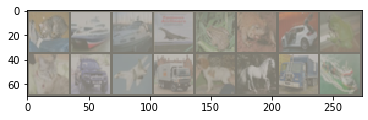

In [0]:
# # Get a batch of training data
# # inputs, classes = next(iter(trainloader))
# adv_tensor = torch.tensor(adversarials)
# # Make a grid from batch
# print(adv_tensor.shape)
# out = torchvision.utils.make_grid(adv_tensor)
# print(out.shape)
# imshow(out)

### Generate and save adversarial images


In [0]:
def gen_adv_images(model, loader, max_samples=None, attack_type="fgsm", **kwargs):
  fin_adv_images = []
  count = 0
  for image, label in loader:
    image, label = image.to(device), label.to(device)
    if attack_type == "fgsm":
        perturbed_images = fgsm_attack(model, image, label, **kwargs)
    elif attack_type == "transfer":
        perturbed_images = transfer_attack(proxy_model, image, label, **kwargs)
    else:
        perturbed_images = cw_attack(model, image, label, **kwargs)

    # Not sure about this next line of code. Do I need to convert to numpy to be able to add this to the empty array fin_adv_images?
    # adv_ex = adv_image.squeeze().detach().cpu().numpy()

    fin_adv_images.append(perturbed_images)
    count += 4
    if max_samples is not None and count >= max_samples:
      return fin_adv_images

  return fin_adv_images

In [0]:
def generate_labels(model, loader, max_samples=None):
  count = 0
  labels = []
  for image, label in testloader:
    labels.append(label)
    count += 4
    if (max_samples is not None) and (count >= max_samples):
      break
      
  print(len(labels))
  labels = torch.cat(labels, dim=0)
  return labels

In [0]:
def gen_adv_images_w_labels(model, loader, max_samples=None, attack_type="fgsm", **kwargs):
  fin_adv_images = []
  labels = []
  count = 0
  for image, label in loader:
    image, label = image.to(device), label.to(device)
    if attack_type == "fgsm":
        perturbed_images = fgsm_attack(model, image, label, **kwargs)
    elif attack_type == "transfer":
        perturbed_images = transfer_attack(proxy_model, image, label, **kwargs)
    else:
        perturbed_images = cw_attack(model, image, label, **kwargs)

    # Not sure about this next line of code. Do I need to convert to numpy to be able to add this to the empty array fin_adv_images?
    # adv_ex = adv_image.squeeze().detach().cpu().numpy()

    fin_adv_images.append(perturbed_images.detach())
    labels.append(label.detach())
    count += BATCH_SIZE

    if count % 1000 == 0:
      print("Finished running ", count)

    if max_samples is not None and count >= max_samples:
      break

  fin_adv_images = torch.cat(fin_adv_images, dim=0)
  labels = torch.cat(labels, dim=0)
  return fin_adv_images, labels

In [0]:
# For running the attack on a subset of data with given start and end index
def gen_adv_images_w_labels_subset(model, loader, start_index=None, end_index=None, attack_type="fgsm", **kwargs):
  fin_adv_images = []
  labels = []
  count = 0

  for image, label in loader:
    count += BATCH_SIZE
    if start_index is not None and count >= start_index and count <= end_index:
      image, label = image.to(device), label.to(device)
      if attack_type == "fgsm":
          perturbed_images = fgsm_attack(model, image, label, **kwargs)
      elif attack_type == "transfer":
          perturbed_images = transfer_attack(proxy_model, image, label, **kwargs)
      else:
          perturbed_images = cw_attack(model, image, label, **kwargs)

    # Not sure about this next line of code. Do I need to convert to numpy to be able to add this to the empty array fin_adv_images?
    # adv_ex = adv_image.squeeze().detach().cpu().numpy()

      # perturbed_images = perturbed_images.
      fin_adv_images.append(perturbed_images.detach())
      labels.append(label.detach())
    
    if end_index is not None and count >= end_index:
      break

  fin_adv_images = torch.cat(fin_adv_images, dim=0)
  labels = torch.cat(labels, dim=0)
  return fin_adv_images, labels

### Different sample sets

In [44]:
all_labels = generate_labels(model, testloader)

2500


In [0]:
torch.save(all_labels, 'all_labels.pt')

#### All CW (only 1200 for now)

In [0]:
# cw_images = gen_adv_images(model, testloader, max_samples = 1200)

# cw_images = torch.cat(cw_images, dim=0)
# print(cw_images.shape)

In [0]:
# torch.save(cw_images2, root_path+'cw_images.pt')

In [0]:
# cw_labels = generate_labels(model, testloader, max_samples = 1200)
# print(cw_labels.shape)

300
torch.Size([1200])


In [0]:
# torch.save(cw_labels, root_path+'cw_labels.pt')

#### All FGSM (epsilon=0.10)

In [0]:
kwargs = {'loss_fn': nn.CrossEntropyLoss(), 'epsilon': 0.10}

In [33]:
fgsm_images, fgsm_labels = gen_adv_images_w_labels(model, testloader, max_samples=10000, attack_type='fgsm', **kwargs)
print(fgsm_images.shape, fgsm_labels.shape)

Finished running  1000
Finished running  2000
Finished running  3000
Finished running  4000
Finished running  5000
Finished running  6000
Finished running  7000
Finished running  8000
Finished running  9000
Finished running  10000
torch.Size([10000, 3, 224, 224]) torch.Size([10000])


In [0]:
torch.save(fgsm_images, root_path+'samples/fgsm_images_010.pt')
torch.save(fgsm_labels, root_path+'samples/fgsm_labels_010.pt')

In [25]:
fgsm_images1, fgsm_labels1 = gen_adv_images_w_labels(model, testloader, max_samples=1200, attack_type='fgsm', **kwargs)
print(fgsm_images1.shape, fgsm_labels1.shape)

Finished running  1000
torch.Size([1200, 3, 224, 224]) torch.Size([1200])


In [0]:
torch.save(fgsm_images1, root_path+'samples/fgsm_images_010_1200.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

In [0]:
fgsm_images2, fgsm_labels2 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=1200, end_index=3099, attack_type='fgsm', **kwargs)
print(fgsm_images2.shape)

In [0]:
torch.save(fgsm_images2, root_path+'samples/fgsm_images_010_1200-3099.pt')
# torch.save(mix_fgsm_labels, 'fgsm_labels_01_1200-3099.pt')

In [32]:
fgsm_images3, fgsm_labels3 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=3100, end_index=4999, attack_type='fgsm', **kwargs)
print(fgsm_images3.shape)

torch.Size([1900, 3, 224, 224])


In [0]:
torch.save(fgsm_images3, root_path+'samples/fgsm_images_010_3100-4999.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

In [38]:
fgsm_images4, fgsm_labels4 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=5000, end_index=7499, attack_type='fgsm', **kwargs)
print(fgsm_images4.shape)

torch.Size([2500, 3, 224, 224])


In [0]:
torch.save(fgsm_images4, root_path+'samples/fgsm_images_010_5000-7499.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

In [21]:
fgsm_images5, fgsm_labels5 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=7500, end_index=9999, attack_type='fgsm', **kwargs)
print(fgsm_images5.shape)

torch.Size([2500, 3, 224, 224])


In [0]:
torch.save(fgsm_images5, root_path+'samples/fgsm_images_010_7500-9999.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

#### All FGSM (epsilon=0.15)

In [0]:
kwargs = {'loss_fn': nn.CrossEntropyLoss(), 'epsilon': 0.15}

In [19]:
fgsm_images_15, fgsm_labels_15 = gen_adv_images_w_labels(model, testloader, max_samples=10000, attack_type='fgsm', **kwargs)
print(fgsm_images_15.shape, fgsm_labels_15.shape)

Finished running  1000
Finished running  2000
Finished running  3000
Finished running  4000
Finished running  5000
Finished running  6000
Finished running  7000
Finished running  8000
Finished running  9000
Finished running  10000
torch.Size([10000, 3, 224, 224]) torch.Size([10000])


In [0]:
torch.save(fgsm_images_15, root_path+'samples/fgsm_images_015.pt')
torch.save(fgsm_labels_15, root_path+'samples/fgsm_labels_015.pt')

In [26]:
fgsm_images21, fgsm_labels21 = gen_adv_images_w_labels(model, testloader, max_samples=1200, attack_type='fgsm', **kwargs)
print(fgsm_images21.shape, fgsm_labels21.shape)

Finished running  1000
torch.Size([1200, 3, 224, 224]) torch.Size([1200])


In [0]:
torch.save(fgsm_images21, root_path+'samples/fgsm_images_015_1200.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

In [29]:
fgsm_images22, fgsm_labels22 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=1200, end_index=3099, attack_type='fgsm', **kwargs)
print(fgsm_images22.shape)

torch.Size([1900, 3, 224, 224])


In [0]:
torch.save(fgsm_images22, root_path+'samples/fgsm_images_015_1200-3099.pt')
# torch.save(mix_fgsm_labels, 'fgsm_labels_01_1200-3099.pt')

In [0]:
fgsm_images3, fgsm_labels3 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=3100, end_index=4999, attack_type='fgsm', **kwargs)
print(fgsm_images3.shape)

torch.Size([1900, 3, 224, 224])


In [0]:
torch.save(fgsm_images3, root_path+'samples/fgsm_images_010_3100-4999.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

In [0]:
fgsm_images4, fgsm_labels4 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=5000, end_index=7499, attack_type='fgsm', **kwargs)
print(fgsm_images4.shape)

torch.Size([2500, 3, 224, 224])


In [0]:
torch.save(fgsm_images4, root_path+'samples/fgsm_images_010_5000-7499.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

In [0]:
fgsm_images5, fgsm_labels5 = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=7500, end_index=9999, attack_type='fgsm', **kwargs)
print(fgsm_images5.shape)

In [0]:
torch.save(fgsm_images5, root_path+'samples/fgsm_images_010_7500-9999.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

#### All Transfer (epsilon=0.10)

In [0]:
kwargs = {'loss_fn': nn.CrossEntropyLoss(), 'epsilon': 0.10}

In [19]:
transfer_images, transfer_labels = gen_adv_images_w_labels(model, testloader, max_samples=10000, attack_type='transfer', **kwargs)
print(transfer_images.shape, transfer_labels.shape)

Finished running  1000
Finished running  2000
Finished running  3000
Finished running  4000
Finished running  5000
Finished running  6000
Finished running  7000
Finished running  8000
Finished running  9000
Finished running  10000
torch.Size([10000, 3, 224, 224]) torch.Size([10000])


In [0]:
torch.save(transfer_images, root_path+'samples/transfer_images_010.pt')
torch.save(transfer_labels, root_path+'samples/transfer_labels_010.pt')

In [21]:
transfer_images3, transfer_labels3 = gen_adv_images_w_labels_subset(model, testloader, 
                                                start_index=3100, end_index=4999, attack_type='transfer', **kwargs)
print(transfer_images3.shape)

torch.Size([1900, 3, 224, 224])


In [0]:
torch.save(transfer_images3, root_path+'samples/transfer_images_010_3100-4999.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

#### All Transfer (epsilon=0.15)

In [0]:
kwargs = {'loss_fn': nn.CrossEntropyLoss(), 'epsilon': 0.15}

In [19]:
transfer_images_15, transfer_labels_15 = gen_adv_images_w_labels(model, testloader, max_samples=10000, attack_type='transfer', **kwargs)
print(transfer_images_15.shape, transfer_labels_15.shape)

Finished running  1000
Finished running  2000
Finished running  3000
Finished running  4000
Finished running  5000
Finished running  6000
Finished running  7000
Finished running  8000
Finished running  9000
Finished running  10000
torch.Size([10000, 3, 224, 224]) torch.Size([10000])


In [0]:
torch.save(transfer_images_15, root_path+'samples/transfer_images_015.pt')
torch.save(transfer_labels_15, root_path+'samples/transfer_labels_015.pt')

In [24]:
transfer_images35, transfer_labels35 = gen_adv_images_w_labels_subset(model, testloader, 
                                                start_index=3100, end_index=4999, attack_type='transfer', **kwargs)
print(transfer_images35.shape)

torch.Size([1900, 3, 224, 224])


In [0]:
torch.save(transfer_images35, root_path+'samples/transfer_images_015_3100-4999.pt')
# torch.save(fgsm_labels, root_path+'fgsm_labels_010.pt')

#### 50-50 FGSM/Transfer (epsilon=0.10)

In [4]:
fgsm_images = torch.load(root_path+"samples/fgsm_images_010.pt")
print(fgsm_images.shape)

torch.Size([10000, 3, 224, 224])


In [5]:
transfer_images = torch.load(root_path+"samples/transfer_images_010.pt")
print(transfer_images.shape)

torch.Size([10000, 3, 224, 224])


In [10]:
import sys
sys.getsizeof(fgsm_images)

72

In [7]:
mixed_samples = torch.cat((fgsm_images[:5000,:,:,:], transfer_images[5000:,:,:,:]))
print(mixed_samples.shape)

RuntimeError: ignored

In [23]:
! nvidia-smi

Tue Dec  3 02:08:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |  12367MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Extra Code - Mixed samples

#### Epsilon = 0.10

In [0]:
kwargs = {'loss_fn': nn.CrossEntropyLoss(), 'epsilon': 0.10}

In [26]:
mix_fgsm_images, mix_fgsm_labels = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=1200, end_index=3099, attack_type='fgsm', **kwargs)
print(mix_fgsm_images.shape, mix_fgsm_labels.shape)

torch.Size([1900, 3, 224, 224]) torch.Size([1900])


In [0]:
mix_fgsm_images, mix_fgsm_labels = gen_adv_images_w_labels_subset(model, testloader, 
                                                  start_index=1200, end_index=3099, attack_type='fgsm', **kwargs)
print(mix_fgsm_images.shape, mix_fgsm_labels.shape)

In [37]:
torch.cuda.memory_allocated()

9355577344

In [0]:
torch.cuda.empty_cache()

In [30]:
!ps -aux|grep python

root          23  0.2  0.8 422196 119712 ?       Sl   19:51   0:14 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         295  3.2 13.9 41303176 1854384 ?    Ssl  20:39   2:13 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-9508abf5-42cc-4e8c-9b18-d77bb9dde5a9.json
root         868  0.0  0.0  39192  6592 ?        S    21:47   0:00 /bin/bash -c ps -aux|grep python


In [0]:
! kill 126

In [0]:
# !cat /proc/cpuinfo

In [48]:
!df -h 

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   40G  301G  12% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       365G   41G  325G  12% /opt/bin
shm             5.9G  2.4M  5.9G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           100G   47G   54G  47% /content/gdrive


In [0]:
# fgsm_images2.detach()